# Sesión 3. Deep Learning aplicado a Visión Artificial

<a href="https://colab.research.google.com/github/ramajoballester/UC3M-PIC/blob/main/notebooks/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales (CNN) clásicas

In [ ]:
# Ejecutar esta celda ÚNICAMENTE si se está trabajando en GOOGLE COLAB

if 'google.colab' in str(get_ipython()):
    import os
    ! git clone https://github.com/ramajoballester/UC3M-PIC.git
    ! pip install uc3m-pic
    os.chdir('UC3M-PIC')
    print('UC3M-PIC instalado en Colab')
else:
    print('Ejecutando en local')

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import thop
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchmetrics
import wandb
import uc3m_pic
from torch import nn
from torchsummary import summary
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
student = uc3m_pic.eval.User('100100100')
student.login(os.path.join('gsheets', 'credentials.json'))
student.open_by_url('https://docs.google.com/spreadsheets/d/1sGXOQo0WgKjllJSdE778EBhU63f-wmSrazeINSnl1a0/edit?usp=sharing')

## Operación de convolución

Las capas totalmente conectadas (*fully-connected*) que se estudiaron previamente tienen una serie de problemas inherentes a su naturaleza. Por ejemplo, si los datos de entrada fueran fotografías de un megapíxel, significaría que cada entrada a la red tendría un millón de dimensiones. Incluso una reducción agresiva a mil dimensiones ocultas requeriría una capa totalmente conectada caracterizada por $10^6 \times 10^3 = 10^9$ parámetros. A menos que se disponga de un gran número de GPU y una extraordinaria paciencia, aprender los parámetros de esta red puede resultar inviable.

Además de ello, un método para reconocer objetos en una imagen debería ser capaz de reconocerlos independientemente de su posición en la imagen. Por ejemplo, si se tiene una imagen de un gato, debería ser capaz de reconocerlo independientemente de si se encuentra en la esquina superior izquierda o en la esquina inferior derecha o de si se encuentra rotado. Es decir, debería ser invariante a la traslación y a la rotación. Por otro lado, normalmente los objetos están definidos principalmente por los elementos más próximos a ellos en lugar de los más alejados, por lo que sería deseable que también se cumpliera el principio de localidad, es decir, que el modelo se centrara en las características locales en un entorno de rango $\pm\Delta$

En matemáticas, la *convolución* entre dos funciones, por ejemplo, $f, g: \mathbb{R}^d \to \mathbb{R}$ se define como:

$$(f * g)(x) = \int f(z) g(x-z) dz$$

Siempre que se tengan elementos discretos, la integral se convierte en una suma. Por ejemplo, para vectores del conjunto de vectores de dimensión infinita con índice $a \in \mathbb{Z}_0^{+}$ se obtiene la siguiente definición:

$$(f * g)(i) = \sum_a f(a) g(i-a)$$

Para tensores bidimensionales, se tiene un sumatorio correspondiente con índices $(a, b)$ para $f$ y $(i-a, j-b)$ para $g$, respectivamente:

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b)$$

Sólo hay un problema con este enfoque. Hasta ahora, se ha ignorado por completo que las imágenes constan de tres canales: rojo, verde y azul. En resumen, las imágenes no son objetos bidimensionales, sino tensores de tercer orden, caracterizados por una altura, una anchura y un número de canales. Para permitir múltiples canales tanto en las entradas ($\mathsf{X}$) como en las representaciones ocultas (o *feature maps*) ($\mathsf{H}$), se puede añadir una cuarta coordenada a $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$. Juntando todo, incluyendo el rango $\Delta$ en el cual se desea aplicar esta convolución se obtiene:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}$$

In [2]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [3]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/correlation.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

In [4]:
0*0 + 1*1 + 3*2 + 4*3

19

In [5]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]))

tensor([[[[19, 25],
          [37, 43]]]])

In [6]:
a.reshape((1, 1, 3, 3)).shape

torch.Size([1, 1, 3, 3])

## Detección de bordes

### Verticales

In [7]:
x = torch.ones((6, 8))
x[:, 2:6] = 0
x

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [38]:
kernel_v = torch.tensor([[1.0, -1.0]])
kernel_v

tensor([[ 1., -1.]])

In [48]:
# Añadimos dos dimensiones (requisito de conv2d)
print(x.shape)
print(x.expand(1, 1, -1, -1).shape)

torch.Size([6, 8])
torch.Size([1, 1, 6, 8])


In [69]:
F.conv2d(x.expand(1, 1, -1, -1), kernel_v.expand(1, 1, -1, -1))

tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])

In [52]:
# Equivalente
F.conv2d(x.view(1, 1, x.shape[0], x.shape[1]), kernel_v.view(1, 1, kernel_v.shape[0], kernel_v.shape[1]))

tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])

### Horizontales

In [53]:
kernel_h = torch.tensor([[1.0],  [-1.0]])
kernel_h

tensor([[ 1.],
        [-1.]])

In [56]:
x_transp = x.T
F.conv2d(x_transp.expand(1, 1, -1, -1), kernel_h.expand(1, 1, -1, -1))

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  1.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [-1., -1., -1., -1., -1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]]]])

### Diagonales

In [59]:
x_ident = torch.eye(6)
x_ident

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [57]:
# SOLUCIÓN:


tensor([[ 0.,  1.],
        [-1.,  0.]])

In [ ]:
kernel_d = ...
kernel_d

tensor([[ 0.,  1.],
        [-1.,  0.]])

In [60]:
F.conv2d(x_ident.expand(1, 1, -1, -1), kernel_d.expand(1, 1, -1, -1))

tensor([[[[ 0., -1.,  0.,  0.,  0.],
          [ 1.,  0., -1.,  0.,  0.],
          [ 0.,  1.,  0., -1.,  0.],
          [ 0.,  0.,  1.,  0., -1.],
          [ 0.,  0.,  0.,  1.,  0.]]]])

In [2]:
batch_size = 512
num_outputs = 47

transform = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])
# target_transform = lambda x: F.one_hot(torch.tensor(x), num_outputs).type(torch.float32)

emnist_path = os.path.join('data', 'emnist')
emnist_train = torchvision.datasets.EMNIST(
    root=emnist_path, split='balanced', train=True, transform=transform, 
    download=True)
emnist_test = torchvision.datasets.EMNIST(
    root=emnist_path, split='balanced', train=False, transform=transform, 
    download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                               shuffle=False, num_workers=0)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [9]:
x_train, y_train = next(iter(test_dataloader))

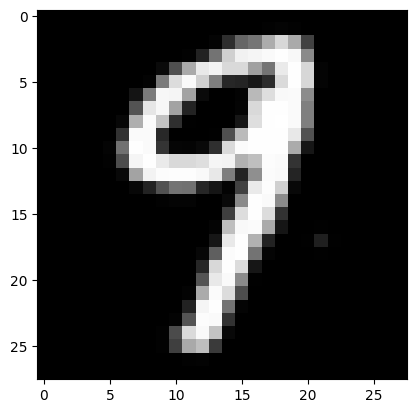

In [77]:
plt.imshow(x_train[2, 0], cmap='gray')
plt.show()

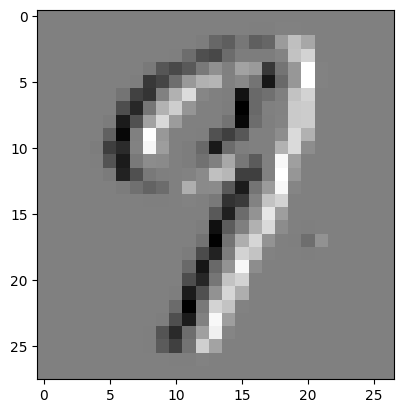

In [79]:
img = F.conv2d(x_train[2, 0].view(1, 1, x_train[2, 0].shape[0], x_train[2, 0].shape[1]),
               kernel_v.view(1, 1, kernel_v.shape[0], kernel_v.shape[1]))
plt.imshow(img[0, 0], cmap='gray')

## Padding

In [2]:
a = torch.arange(0, 9).reshape(3, 3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [3]:
# Izquierda, derecha, arriba, abajo
a_pad = F.pad(a, (1, 1, 1, 1))
a_pad

tensor([[0, 0, 0, 0, 0],
        [0, 0, 1, 2, 0],
        [0, 3, 4, 5, 0],
        [0, 6, 7, 8, 0],
        [0, 0, 0, 0, 0]])

In [4]:
kernel = torch.arange(0, 4).reshape(2, 2)
kernel

tensor([[0, 1],
        [2, 3]])

In [5]:
F.conv2d(a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]))

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-pad.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:60vw"/>

In [6]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         padding=(1, 1))

tensor([[[[ 0,  3,  8,  4],
          [ 9, 19, 25, 10],
          [21, 37, 43, 16],
          [ 6,  7,  8,  0]]]])

In [7]:
F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         padding='same')

/tmp/ipykernel_366083/2887868998.py:1: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/Convolution.cpp:1003.)
  F.conv2d(a.view(1, 1, a.shape[0], a.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),


tensor([[[[19, 25, 10],
          [37, 43, 16],
          [ 7,  8,  0]]]])

## Stride

In [8]:
F.conv2d(a_pad.view(1, 1, a_pad.shape[0], a_pad.shape[1]), kernel.view(1, 1, kernel.shape[0], kernel.shape[1]),
         stride=(3, 2))

tensor([[[[0, 8],
          [6, 8]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-stride.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

In [20]:
class ConvModelStride(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 64, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 8, 3)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*5*5, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [22]:
model_stride = ConvModelStride()

In [14]:
# Calcular tamaño de salida de una capa convolucional a partir del 
# tamaño de entrada, tamaño del kernel, padding y stride
def conv2d_output_size(input_size, kernel_size, padding=0, stride=1):
    return (input_size + 2*padding - kernel_size) // stride + 1

In [16]:
# Salida primera capa
conv2d_output_size(input_size=28, kernel_size=5, padding=2, stride=2)

14

In [17]:
# Salida segunda capa
conv2d_output_size(input_size=14, kernel_size=5, padding=2, stride=2)

7

In [18]:
# Salida tercera capa
conv2d_output_size(input_size=7, kernel_size=3)

5

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(model_stride.to(device), (1, 28, 28))
flops, params = thop.profile(model_stride, verbose=False,
                             inputs=(torch.randn(1, 1, 28, 28).to(device),))
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             416
            Conv2d-2             [-1, 64, 7, 7]          25,664
            Conv2d-3              [-1, 8, 5, 5]           4,616
           Flatten-4                  [-1, 200]               0
            Linear-5                   [-1, 47]           9,447
Total params: 40,143
Trainable params: 40,143
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.15
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
FLOPs: 1.46M, params: 40.14K


## Pooling

In [25]:
a = torch.arange(0, 9, dtype=torch.float32).reshape(3, 3)
a

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [26]:
F.max_pool2d(a.unsqueeze(0), (2, 2), stride=1)

tensor([[[4., 5.],
         [7., 8.]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/pooling.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

## Múltiples canales de entrada y salida

In [27]:
a = torch.stack([torch.arange(0, 9).reshape(3, 3), torch.arange(1, 10).reshape(3, 3)])
a

tensor([[[0, 1, 2],
         [3, 4, 5],
         [6, 7, 8]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [28]:
kernel = torch.stack([torch.arange(0, 4).reshape(2, 2), torch.arange(1, 5).reshape(2, 2)])
kernel

tensor([[[0, 1],
         [2, 3]],

        [[1, 2],
         [3, 4]]])

In [29]:
F.conv2d(a.unsqueeze(0), kernel.unsqueeze(0))

tensor([[[[ 56,  72],
          [104, 120]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-multi-in.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:60vw"/>

## Convolución 1x1

In [ ]:
a = torch.arange(0, 3*3*3).reshape(3, 3, 3)
a

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])

In [ ]:
kernel = torch.arange(0, 6).reshape(2, 3, 1, 1)
kernel

tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[3]],

         [[4]],

         [[5]]]])

In [ ]:
F.conv2d(a.unsqueeze(0), kernel)

tensor([[[[ 45,  48,  51],
          [ 54,  57,  60],
          [ 63,  66,  69]],

         [[126, 138, 150],
          [162, 174, 186],
          [198, 210, 222]]]])

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/conv-1x1.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:50vw"/>

# Optimización del entrenamiento

## Paralelización y velocidad de entrenamiento

- GPU
- num_workers (ejemplo tortilla de patatas)
- batch_size

In [63]:
batch_size = 256

transf = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.EMNIST(
    root='data', split='balanced', train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.EMNIST(
    root='data', split='balanced', train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True, num_workers=8,
                                               pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                              shuffle=False, num_workers=8,
                                              pin_memory=True)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*16*16, 47)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

### CPU

In [59]:
device = torch.device('cpu')
model = CNN().to(device)

lr = 0.0001
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
%%timeit -n 1 -r 1
# batch_size = 16, num_workers = 1
model = CNN().to(device)
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss_fn(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 3min 21s per loop


In [ ]:
%%timeit -n 1 -r 1
# batch_size = 256, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss_fn(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 3min 18s per loop


### GPU

In [60]:
device = torch.device('cuda')
model = CNN().to(device)

lr = 0.0001
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
%%timeit -n 1 -r 1
# batch_size = 16, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss_fn(y_pred, y)
    l.backward()
    optimizer.step()

1 loop, best of 1: 41.7 s per loop


In [62]:
%%timeit -n 1 -r 1
# batch_size = 256, num_workers = 1
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss_fn(y_pred, y)
    l.backward()
    optimizer.step()

8.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [64]:
%%timeit -n 1 -r 1
# batch_size = 256, num_workers = 8
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    l = loss_fn(y_pred, y)
    l.backward()
    optimizer.step()

2.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Número de parámetros

In [ ]:
model = CNN()

In [ ]:
summary(model.to(torch.device('cuda')), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
            Conv2d-2           [-1, 64, 20, 20]          25,664
            Conv2d-3            [-1, 8, 16, 16]          12,808
           Flatten-4                 [-1, 2048]               0
            Linear-5                   [-1, 47]          96,303
Total params: 135,191
Trainable params: 135,191
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.52
Estimated Total Size (MB): 0.82
----------------------------------------------------------------


In [ ]:
w1 = 1*16*5*5 + 16
w1

416

In [ ]:
w2 = 16*64*5*5 + 64
w2

25664

In [ ]:
w3 = 64*8*5*5 + 8
w3

12808

In [ ]:
w4 = 8*16*16*47 + 47
w4

96303

In [ ]:
w1 + w2 + w3 + w4

135191

# Ejercicio 3: EuroSAT

In [92]:
# SOLUCIÓN:


In [ ]:
def train(model, dataloader, loss_fn, optimizer):
    
    '''
    Training loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to train
    dataloader : torch.utils.data.DataLoader
        Dataloader with the training data
    loss_fn : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer

    Returns
    -------
    None
    '''
    
    ...


def test(model, dataloader, loss_fn, metrics_fn):
    
    '''
    Test loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to test
    dataloader : torch.utils.data.DataLoader
        Dataloader with the testing data
    loss_fn : torch.nn.Module
        Loss function
    metrics_fn : torchmetrics.Metric
        Metric function

    Returns
    -------
    loss : float
        Loss value
    metrics : float
        Metric value
    '''
    
    ...

In [82]:
# SOLUCIÓN:


In [ ]:
class EuroSATModel(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        ...

    def forward(self, x):
        ...

        return out

In [13]:
# Calculo del tamaño de salida de una capa convolucional a partir del tamaño
# de entrada, tamaño del kernel, padding y stride de las capas convolucionales
# y pooling
def conv2d_output_size(input_size, kernel_size, padding=0, stride=1,
                          pool_kernel_size=1, pool_stride=1):
    
    conv_output = (input_size + 2*padding - kernel_size) // stride + 1
    pool_output = (conv_output - pool_kernel_size) // pool_stride + 1

    return pool_output

In [57]:
conv2d_output_size(input_size=64, kernel_size=5, padding=0, stride=1, 
                   pool_kernel_size=3, pool_stride=2)

29

In [81]:
# Probar que las dimensiones de las capas son correctas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EuroSATModel().to(device)
summary(model, (3, 64, 64))
# Calcular FLOPs
flops, params = thop.profile(model, verbose=False,
                             inputs=(torch.randn(1, 3, 64, 64).to(device),))
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]           1,216
            Conv2d-2           [-1, 64, 13, 13]          25,664
            Conv2d-3            [-1, 128, 5, 5]          73,856
            Linear-4                  [-1, 256]         819,456
            Linear-5                   [-1, 10]           2,570
Total params: 922,762
Trainable params: 922,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.55
Params size (MB): 3.52
Estimated Total Size (MB): 4.12
----------------------------------------------------------------
FLOPs: 11.31M, params: 922.76K


In [88]:
# Carga del dataset

batch_size = 256
num_outputs = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

eurosat_dataset = torchvision.datasets.EuroSAT(
    root='data', transform=transform, 
    download=True)

# No modificar la semilla de aleatoriedad (random_state)
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(strat_split.split(eurosat_dataset, eurosat_dataset.targets))
train_dataset = torch.utils.data.Subset(eurosat_dataset, train_idx)
test_dataset = torch.utils.data.Subset(eurosat_dataset, test_idx)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size,
                                                shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size,
                                                shuffle=False, num_workers=8)

labels = eurosat_dataset.classes

In [28]:
x, y = next(iter(train_dataloader))

Industrial


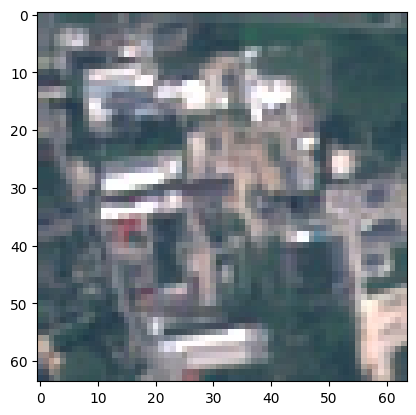

In [49]:
# Visualización del dataset
idx = np.random.randint(0, len(x))
plt.imshow(x[idx].permute(1, 2, 0))
print(labels[y[idx]])

In [95]:
# SOLUCIÓN:


In [ ]:
# GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Learning rate
lr = ...
# Número de epochs de entrenamiento
num_epochs = ...
# Modelo de regresión softmax
model = ...


# Función de pérdida
loss_fn = ...
# Métrica de precisión
metrics_fn = ...
# Optimizador
optimizer = ...

config = {
  'learning_rate':lr,
  'epochs': num_epochs,
  'batch_size': batch_size,
  'optimizer': optimizer.__class__.__name__
}

In [ ]:
# SOLUCIÓN:


In [ ]:
wandb.init(project="uc3m-pic", name='Ejercicio 3', config=config);

best_acc = 0
for epoch in range(1, num_epochs):
    
    ...


wandb.finish()

In [107]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=3)

Score: 0.6796296238899231 submitted to exercise 3


# Mejora del rendimiento

## LR scheduler

[LR schedulers Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

In [ ]:
# Integración en el bucle de entrenamiento
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
### LR scheduler fuera del bucle
lr_scheduler.step()
###

## Optimizadores 

[Optimizadores Pytorch](https://pytorch.org/docs/stable/optim.html#algorithms)


Choi, D., Shallue, C. J., Nado, Z., Lee, J., Maddison, C. J., & Dahl, G. E. (2019). **On empirical comparisons of optimizers for deep learning.**  arXiv preprint arXiv:1910.05446. [Paper](https://arxiv.org/pdf/1910.05446.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/optimizers.png"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:90vw"/>

## Aumentación de datos

In [ ]:
# Diferentes transforms en train y test
torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(18),
    torchvision.transforms.RandomHorizontalFlip(0.25),
    torchvision.transforms.RandomVerticalFlip(0.25),
    torchvision.transforms.RandomAffine(15),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    torchvision.transforms.ToTensor()
])

Compose(
    RandomResizedCrop(size=(18, 18), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.25)
    RandomVerticalFlip(p=0.25)
    RandomAffine(degrees=[-15.0, 15.0])
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ToTensor()
)

## Regularización

### L1, L2

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)

### Dropout

In [4]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*16*16, 47)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        # Equivalente con API funcional
        # x = F.dropout2d(x, p=0.5)
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(ConvModel().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
            Conv2d-2           [-1, 64, 20, 20]          25,664
           Dropout-3           [-1, 64, 20, 20]               0
            Conv2d-4            [-1, 8, 16, 16]          12,808
           Flatten-5                 [-1, 2048]               0
            Linear-6                   [-1, 47]          96,303
Total params: 135,191
Trainable params: 135,191
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 0.52
Estimated Total Size (MB): 1.01
----------------------------------------------------------------


### Batch normalization

In [9]:
# Create the same model with batch normalization
class ConvModelBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 8, 5)
        self.bn3 = nn.BatchNorm2d(8)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(8*16*16, 47)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.flat(x)
        x = self.linear(x)

        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(ConvModelBN().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
       BatchNorm2d-2           [-1, 16, 24, 24]              32
            Conv2d-3           [-1, 64, 20, 20]          25,664
       BatchNorm2d-4           [-1, 64, 20, 20]             128
            Conv2d-5            [-1, 8, 16, 16]          12,808
       BatchNorm2d-6            [-1, 8, 16, 16]              16
           Flatten-7                 [-1, 2048]               0
            Linear-8                   [-1, 47]          96,303
Total params: 135,367
Trainable params: 135,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 0.52
Estimated Total Size (MB): 1.10
----------------------------------------------------------------


## Campo receptivo y mapa de características

Normalmente, al procesar las imágenes, se busca reducir gradualmente la resolución espacial de las representaciones ocultas, agregando la información de forma que, cuanto más subimos en la red, mayor es el campo receptivo (en la entrada) al que es sensible cada neurona.

- Receptive field
- Feature map

# Ejercicio 4: Imagenette

Descargar dataset [Imagenette-320px](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz), guardar en la carpeta `data` y extraer (`tar zxvf imagenette2-320.tgz` desde la línea de comandos en Linux / Mac).

In [11]:
# SOLUCIÓN:


In [ ]:
# Redefinir si es necesario
def train(model, dataloader, loss_fn, optimizer, scheduler=None):
    
    '''
    Training loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to train
    dataloader : torch.utils.data.DataLoader
        Dataloader with the training data
    loss_fn : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler

    Returns
    -------
    None
    '''
    
    ...

def test(model, dataloader, loss_fn, metrics_fn):
    
    '''
    Test loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to test
    dataloader : torch.utils.data.DataLoader
        Dataloader with the testing data
    loss_fn : torch.nn.Module
        Loss function
    metrics_fn : torchmetrics.Metric
        Metric function

    Returns
    -------
    loss : float
        Loss value
    metrics : float
        Metric value
    '''
    
    ...

In [12]:
# SOLUCIÓN:


In [ ]:
class ImagenetteModel(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        ...

    def forward(self, x):
        ...

        return out

In [19]:
conv2d_output_size(input_size=425, kernel_size=11, padding=0, stride=4, 
                   pool_kernel_size=5, pool_stride=3)

34

In [20]:
conv2d_output_size(input_size=320, kernel_size=11, padding=0, stride=3, 
                   pool_kernel_size=5, pool_stride=3)

34

In [13]:
# Probar que las dimensiones de las capas son correctas
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImagenetteModel(10).to(device)
summary(model, (3, 320, 425))
# Calcular FLOPs
flops, params = thop.profile(model, verbose=False,
                             inputs=(torch.randn(1, 3, 320, 425).to(device),))
(flops, params) = thop.clever_format([flops, params])
print(f'FLOPs: {flops}, params: {params}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 104, 104]          23,296
            Conv2d-2          [-1, 256, 15, 15]         409,856
            Conv2d-3           [-1, 1024, 5, 5]       2,360,320
            Linear-4                  [-1, 256]       1,048,832
            Linear-5                   [-1, 10]           2,570
Total params: 3,844,874
Trainable params: 3,844,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.56
Forward/backward pass size (MB): 5.92
Params size (MB): 14.67
Estimated Total Size (MB): 22.14
----------------------------------------------------------------
FLOPs: 403.47M, params: 3.84M


In [14]:
batch_size = 64

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((320, 425), antialias=True)
])

# Load imagenette dataset from local files
train_path = os.path.join('data', 'imagenette2-320', 'train')
test_path = os.path.join('data', 'imagenette2-320', 'val')
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size,
                                                shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size,
                                                shuffle=False, num_workers=4)

labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
          'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

In [7]:
x, y = next(iter(train_dataloader))

In [18]:
%%timeit -n 1 -r 1
x, y = next(iter(train_dataloader))

3.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


gas pump


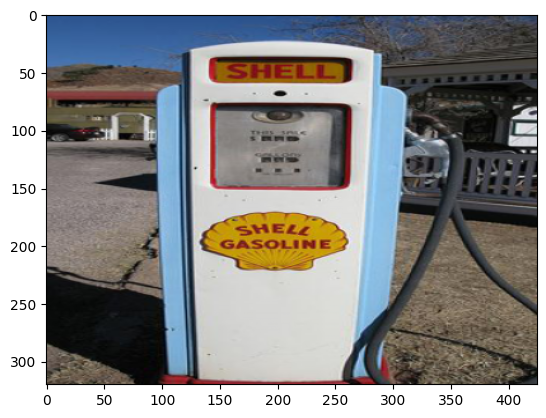

In [11]:
# Visualización del dataset
idx = np.random.randint(0, len(x))
plt.imshow(x[idx].permute(1, 2, 0))
print(labels[y[idx]])

In [17]:
# SOLUCIÓN:


In [ ]:
# GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Número de clases
num_outputs = len(labels)
# Learning rate
lr = ...
# Número de epochs de entrenamiento
num_epochs = ...
# Modelo de regresión softmax
model = ...

# Función de pérdida
loss_fn = ...
# Métrica de precisión
metrics_fn = ...
# Optimizador
optimizer = ...
# LR scheduler
lr_scheduler = ...

config = {
  'learning_rate':lr,
  'epochs': num_epochs,
  'batch_size': batch_size,
  'optimizer': optimizer.__class__.__name__,
  'lr_scheduler': lr_scheduler.__class__.__name__
}

In [ ]:
# SOLUCIÓN:


In [ ]:
wandb.init(project="uc3m-pic", name='Ejercicio 4', config=config);

best_acc = 0
for epoch in range(1, num_epochs):
    
    ...

wandb.finish()

In [ ]:
# Evaluar modelo y subir resultados al leaderboard
student.submit(best_model, exercise=4)

# LeNet: el primer modelo de CNN

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324. [Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=726791&casa_token=kyltN8hTCx0AAAAA:uFdBXu6A_S6S4cpFwgx2_d3tAosoljC-2VWHpvIB8nCIlUbHAaxNO_3iZkeNgEUDVbvmlGJeVQ&tag=1)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/lenet-vert.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:15vw"/>

- Entrada (28 x 28)
- 6 filtros convolucionales, kernel 5 x 5, padding=2
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- 16 filtros convolucionales, kernel 5 x 5
 - Función de activación sigmoide
 - Average pooling 2 x 2, stride=2
- Lineal 120 neuronas
  - Función de activación sigmoide
- Lineal 84 neuronas
  - Función de activación sigmoide
- Lineal num_clases neuronas

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 47)
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 47]           3,995
Total params: 64,851
Trainable params: 64,851
Non-trainable params: 0
---------------------------------

# CNN modernas

## AlexNet

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.

[Paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/alexnet.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:30vw"/>

## VGG (transfer learning)

<img src="https://raw.githubusercontent.com/ramajoballester/UC3M-PIC/main/data/content/vgg.svg"
    style="background-color:white; display:block; margin-left:auto; margin-right:auto; width:40vw"/>

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## ResNet

In [ ]:
model = torchvision.models.resnet152(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## EfficientNet (B0 - B7)

In [ ]:
model = torchvision.models.efficientnet_b7(pretrained=True)

In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

# Referencias

- [Guía de diseño](https://d2l.ai/chapter_convolutional-modern/cnn-design.html) de redes neuronales convolucionales
- [Stanford CS231n](https://cs231n.github.io/convolutional-networks/): redes neuronales convolucionales
- Comparativa de velocidad [Pytorch 2.0 vs 1.x](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#demonstrating-speedups)